# 1 Set up and get DATA

In [1]:
#Import

import matplotlib.pyplot as plt
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data', 'images')
numb_images = 30

In [6]:
cap = cv2.VideoCapture(1)
for imgnum in range(numb_images):
    print("Cellecting image : {}".format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.png')
    cv2.imwrite(imgname, frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

Cellecting image : 0
Cellecting image : 1
Cellecting image : 2
Cellecting image : 3
Cellecting image : 4
Cellecting image : 5
Cellecting image : 6
Cellecting image : 7
Cellecting image : 8
Cellecting image : 9
Cellecting image : 10
Cellecting image : 11
Cellecting image : 12
Cellecting image : 13
Cellecting image : 14
Cellecting image : 15
Cellecting image : 16
Cellecting image : 17
Cellecting image : 18
Cellecting image : 19
Cellecting image : 20
Cellecting image : 21
Cellecting image : 22
Cellecting image : 23
Cellecting image : 24
Cellecting image : 25
Cellecting image : 26
Cellecting image : 27
Cellecting image : 28
Cellecting image : 29


# 2. Review dataset ad build image loading Function

In [7]:
import tensorflow as tf
import json
import numpy as np

In [8]:
# Limit GPU Memory Growth

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [9]:
tf.config.list_logical_devices('GPU')

[]

In [ ]:
# Load images

images = tf.data.Dataset.list_files('data/images/*.png', shuffle=False)

In [47]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_png(byte_img)
    return img

In [48]:
images = images.map(load_image)

In [49]:
images.as_numpy_iterator().next().shape

(1080, 1920, 3)

In [50]:
image_generator = images.batch(4).as_numpy_iterator()

In [60]:
plot_images = image_generator.next()

2024-04-29 20:54:29.755000: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: data/images/2e9f128e-04c9-11ef-b311-fa6804503739.png; No such file or directory
2024-04-29 20:54:29.755044: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: data/images/2e43ac82-04c9-11ef-b311-fa6804503739.png; No such file or directory
2024-04-29 20:54:29.755096: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: data/images/2efa219c-04c9-11ef-b311-fa6804503739.png; No such file or directory
2024-04-29 20:54:29.755135: W tensorflow/core/framework/op_kernel.cc:1839] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: data/images/2f53ba18-04c9-11ef-b311-fa6804503739.png; No such file or directory


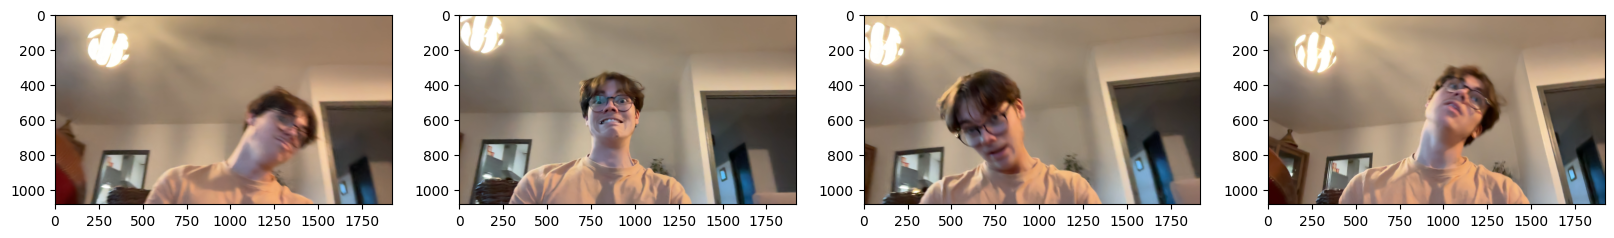

In [61]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [ ]:
# Move the matching labels

for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):

        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

## 4.Apply Image Augmentation on images and labels using Albumentations

In [71]:
import albumentations as alb

In [72]:
augmentation = alb.Compose([alb.RandomCrop(450, 450),
                            alb.HorizontalFlip(p=0.5),
                            alb.RandomBrightnessContrast(p=0.2),
                            alb.RandomGamma(p=0.2),
                            alb.RGBShift(p=0.2),
                            alb.VerticalFlip(p=0.5)],
                            bbox_params=alb.BboxParams(format='albumentations',
                                                        label_fields=['class_labels']))


In [74]:
# Example
img = cv2.imread(os.path.join('data', 'train', 'images','00c3a280-04c9-11ef-b311-fa6804503739.png'))

In [89]:
img.shape

(1080, 1920, 3)

In [76]:
with open(os.path.join('data', 'train', 'labels', '00c3a280-04c9-11ef-b311-fa6804503739.json')) as f:
    label = json.load(f)

In [87]:
# Extract coordinates

coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [88]:
coords = list(np.divide(coords, [1920, 1080, 1920, 1080]))

[787.3333333333334, 366.0, 1282.0, 986.0]